In [24]:
import sys
sys.path.append('..')

In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
from typing import List
import numpy as np
from tqdm.notebook import trange as trange
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

from utils.data_utils import *
from test_framework.model_interface import ModelInterface
from test_framework.tester import Tester
from test_framework.metrics import *
from active_learning.categorical_query_functions import *
from active_learning.gradient_embedding import compute_gradient_embeddings
from active_learning.cluster_margin import *

## Dataset and Model Constants

In [27]:
# Data Constants
DATA_DIR = "../data/kaggle_satellite_image_classification"
NUM_CLASSES = 4
MAIN_IMG_DIMS = (64, 64)
SECONDARY_IMG_DIMS = (32, 32)
MAX_SECONDARY_IMAGES = 5

# Model Constants
FINAL_LAYER_LEN = 64

# Training Constants
TEST_DATA_FRACTION = 0.05

## Load Dataset, creating secondary modality

0.62468696
Label = [0. 1. 0. 0.]


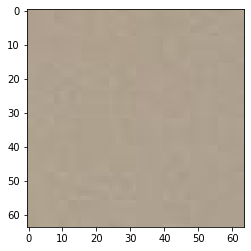

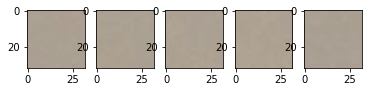

Label = [0. 0. 1. 0.]


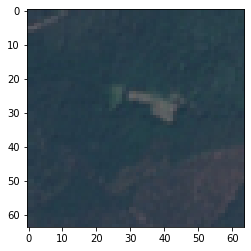

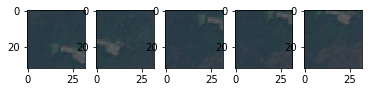

Label = [0. 0. 1. 0.]


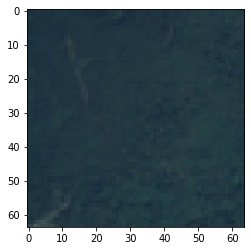

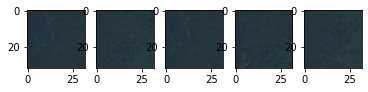

Label = [0. 1. 0. 0.]


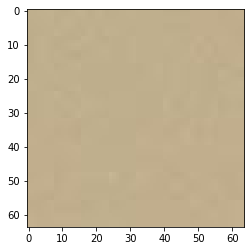

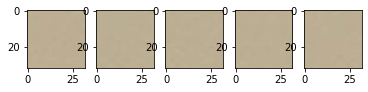

In [28]:
def load_dataset_as_numpy(max_samples: int = None):
    def transform_to_multimodal(image):
        main_image = transforms.Compose([
            transforms.CenterCrop(MAIN_IMG_DIMS),
            transforms.ToTensor(),
            #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])(image.copy())

        secondary_images = [
            transforms.Compose([
                transforms.RandomCrop(SECONDARY_IMG_DIMS),
                transforms.ToTensor(),
                #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                transforms.Lambda(lambda img: transforms.functional.adjust_contrast(img, contrast_factor=0.8))
            ])(image.copy()) for i in range(MAX_SECONDARY_IMAGES)
        ]
        secondary_images = torch.stack(secondary_images)
        
        return main_image, secondary_images

    dataset = datasets.ImageFolder(DATA_DIR, transform=transform_to_multimodal)
    output_sample_count = len(dataset) if max_samples is None or max_samples >= len(dataset) else max_samples
    all_data_dataloader = torch.utils.data.DataLoader(dataset, batch_size=output_sample_count, num_workers=0, shuffle=True)
    (main_image_all, secondary_images_all), y_all = next(iter(all_data_dataloader))

    # Convert y to one-hot array
    y_all = torch.eye(NUM_CLASSES)[y_all]

    return main_image_all.numpy(), secondary_images_all.numpy(), y_all.numpy()

x_main, x_secondary, y = load_dataset_as_numpy()


# Display some examples
print(np.mean(x_main[0]))
for i in range(4):
    print(f"Label = {y[i]}")
    plt.imshow(x_main[i].transpose(1, 2, 0))
    plt.show()
    fig, axarr = plt.subplots(1, MAX_SECONDARY_IMAGES)
    for j in range(MAX_SECONDARY_IMAGES):
        axarr[j].imshow(x_secondary[i][j].transpose(1, 2, 0))
    plt.show()
plt.close('all')

In [29]:
print(x_secondary.shape)
x_main.shape

(4624, 5, 3, 32, 32)


(4624, 3, 64, 64)

## Create Simple Late Fusion Model

In [30]:
class MultiModalLateFusionModel(nn.Module):
    def __init__(self):
        super(MultiModalLateFusionModel, self).__init__()

        # Simple convolutional network operates on original full images,
        # and outputs a set of features useful for a final classification layer
        self.main_branch = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 16, kernel_size=1, padding=0),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(16 * (MAIN_IMG_DIMS[0] // 2**3) * (MAIN_IMG_DIMS[1] // 2**3), FINAL_LAYER_LEN // 2),
            nn.Tanh()
        )

        # This secondary branch operates on cropped parts of the image with
        # increased contrast. If there are multiple secondary images, we use
        # the average of the features output by this branch
        self.secondary_branch = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 16, kernel_size=1, padding=0),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(16 * (SECONDARY_IMG_DIMS[0] // 2**3) * (SECONDARY_IMG_DIMS[1] // 2**3), FINAL_LAYER_LEN // 2),
            nn.Tanh()
        )

        # Single dense layer which combines information directly after fusing both model modes
        self.post_fusion_layer = nn.Linear(FINAL_LAYER_LEN, NUM_CLASSES)


    '''
    Args:
        main_image (torch.Tensor):          Shape = (batch_size, 3, *(MAIN_IMG_DIMS))
        secondary_images (torch.Tensor):    Variable size list of cropped high-contrast parts
                                            of the main image. The list is padded to the max
                                            length with images of all zeros.
                                            Shape = (batch_size, MAX_SECONDARY_IMAGES, 3, *(SECONDARY_IMG_DIMS))  
    '''
    def forward(self, main_image: torch.Tensor, secondary_images: torch.Tensor) -> torch.Tensor:
        batch_size = main_image.shape[0]
        
        # Compute main branch
        main_features = self.main_branch(main_image)

        # Count the number of secondary images
        slot_has_image = (secondary_images != torch.zeros(3, *SECONDARY_IMG_DIMS).to(DEVICE)).reshape(batch_size, MAX_SECONDARY_IMAGES, -1).prod(dim=-1, keepdim=True) # shape = (batch_size, MAX_SECONDARY_IMAGES, 1)
        image_count_per_sample = slot_has_image.sum(dim=1) # shape = (batch_size, 1)

        # Compute features for every possible secondary image
        all_secondary_images = secondary_images.reshape(batch_size * MAX_SECONDARY_IMAGES, 3, *SECONDARY_IMG_DIMS)
        all_secondary_features = self.secondary_branch(all_secondary_images).reshape(batch_size, MAX_SECONDARY_IMAGES, -1)

        # Mask out features for secondary image slots that didn't contain an actual image (i.e. were all zeros)
        masked_secondary_image_features = all_secondary_features * slot_has_image

        # Average the secondary branch features of all included secondary branches
        averaged_secondary_image_features = masked_secondary_image_features.sum(dim=1) / image_count_per_sample

        # Concatenate both feature modes
        fused_features = torch.cat([main_features, averaged_secondary_image_features], dim=1)

        # Pass through final layer
        output_logits = self.post_fusion_layer(fused_features)

        output_probabilities = torch.softmax(output_logits, dim=1)
        return output_probabilities

## Create Model Interface to plug model into active learning test framework

In [31]:
# This interface uses the multimodal model above with a specified query function
class MultiModalLateFusionModelInterface(ModelInterface):
    def __init__(self, query_function_name: str, active_learning_batch_size: int = 32):
        self.query_function_name = query_function_name
        self.active_learning_batch_size = active_learning_batch_size

        # Model Training Constants
        self.TRAINING_MINIBATCH_SIZE = 128

        self.reset()
        

    def name(self):
        return self.query_function_name

    def reset(self):
        self.model = MultiModalLateFusionModel().to(DEVICE)
        self.opt = torch.optim.Adam(self.model.parameters(), lr=1e-3)

        # For cluster-margin active learning algorithm, clusters must be
        # saved between queries
        if self.query_function_name == "CLUSTER_MARGIN":
            self.cluster_margin = ClusterMarginQueryFunction(
                self.model, [self.model.post_fusion_layer.weight],
                margin_batch_size = 2 * self.active_learning_batch_size,
                target_batch_size = self.active_learning_batch_size
            )
        else:
            self.cluster_margin = None

    def train(self, train_x: List[np.ndarray], train_y: np.ndarray) -> None:
        data_len = train_y.shape[0]

        # Extract specific data modes
        x_main, x_secondary = train_x
        
        # Pass through all minibatches in training set, but skip any partial minibatch at the end
        batch_start = 0
        while batch_start + self.TRAINING_MINIBATCH_SIZE < data_len:
            x_main_minibatch = torch.from_numpy(x_main[batch_start : batch_start + self.TRAINING_MINIBATCH_SIZE]).to(DEVICE)
            x_secondary_minibatch = torch.from_numpy(x_secondary[batch_start : batch_start + self.TRAINING_MINIBATCH_SIZE]).to(DEVICE)
            y_minibatch = torch.from_numpy(train_y[batch_start : batch_start + self.TRAINING_MINIBATCH_SIZE]).to(DEVICE)

            # Train on minibatch
            self.opt.zero_grad()

            model_output = self.model(
                x_main_minibatch,
                x_secondary_minibatch
            )

            # Compute cross-entropy loss
            loss = -torch.mean(torch.sum(y_minibatch * torch.log(model_output + 1e-9), dim=1))
            loss.backward()
            self.opt.step()

            # Iterate minibatch
            batch_start += self.TRAINING_MINIBATCH_SIZE

    def predict(self, test_x: List[np.ndarray]) -> np.ndarray:
        data_len = test_x[0].shape[0]
        output = np.zeros((data_len, NUM_CLASSES))

        with torch.no_grad():
            # Extract specific data modes
            x_main, x_secondary = test_x

            # Iterate through minibatches without skipping partial ending
            batch_start = 0
            while batch_start < data_len:
                current_minibatch_size = min(self.TRAINING_MINIBATCH_SIZE, data_len - batch_start)

                # Convert to tensors
                x_main_minibatch = torch.from_numpy(x_main[batch_start : batch_start + current_minibatch_size]).to(DEVICE)
                x_secondary_minibatch = torch.from_numpy(x_secondary[batch_start : batch_start + current_minibatch_size]).to(DEVICE)
                
                predictions = self.model(
                    x_main_minibatch,
                    x_secondary_minibatch
                )
                output[batch_start : batch_start + current_minibatch_size] = predictions.cpu().numpy()

                # Iterate minibatch
                batch_start += current_minibatch_size

        return output

    def query(self, unlabeled_data: List[np.ndarray], labeling_batch_size: int) -> np.ndarray:
        if self.query_function_name == "RANDOM":
            data_size = unlabeled_data[0].shape[0]
            return np.random.choice(np.arange(data_size), size=labeling_batch_size, replace=False)
        
        if self.query_function_name == "MIN_MAX":
            return MIN_MAX(self.predict(unlabeled_data), labeling_batch_size)

        if self.query_function_name == "MIN_MARGIN":
            return MIN_MARGIN(self.predict(unlabeled_data), labeling_batch_size)

        if self.query_function_name == "MAX_ENTROPY":
            return MAX_ENTROPY(self.predict(unlabeled_data), labeling_batch_size)

        if self.query_function_name == "CLUSTER_MARGIN":
            return self.cluster_margin.query(unlabeled_data)

        raise ValueError(f"Unrecognized query function name: {self.query_function_name}")

## Test model with full dataset

In [39]:
# split dataset
def train_test_split(x, shuffle_indices, train_percentage):
    # np.random.shuffle(x)
    x = x[shuffle_indices]
    print(x.shape)
    print(x[:int(x.shape[0]*train_percentage)].shape)
    return x[:int(x.shape[0]*train_percentage)], x[int(x.shape[0]*train_percentage):]

shuffle_indices = np.random.permutation(x_main.shape[0])
x_main_train, x_main_test = train_test_split(x_main, shuffle_indices, 0.7)
x_secondary_train, x_secondary_test = train_test_split(x_secondary, shuffle_indices, 0.7)
y_train, y_test = train_test_split(y, shuffle_indices, 0.7)

(4624, 3, 64, 64)
(3236, 3, 64, 64)
(4624, 5, 3, 32, 32)
(3236, 5, 3, 32, 32)
(4624, 4)
(3236, 4)


In [46]:
num_epochs = 40
model = MultiModalLateFusionModelInterface('NONE')
performances = list()
for i in range(num_epochs):
    print("on epoch {}".format(i))
    model.train((x_main_train, x_secondary_train), y_train)
    preds = model.predict((x_main_test, x_secondary_test))
    performances.append(ACCURACY(preds, y_test))

on epoch 0
on epoch 1
on epoch 2
on epoch 3
on epoch 4
on epoch 5
on epoch 6
on epoch 7
on epoch 8
on epoch 9
on epoch 10
on epoch 11
on epoch 12
on epoch 13
on epoch 14
on epoch 15
on epoch 16
on epoch 17
on epoch 18
on epoch 19
on epoch 20
on epoch 21
on epoch 22
on epoch 23
on epoch 24
on epoch 25
on epoch 26
on epoch 27
on epoch 28
on epoch 29
on epoch 30
on epoch 31
on epoch 32
on epoch 33
on epoch 34
on epoch 35
on epoch 36
on epoch 37
on epoch 38
on epoch 39


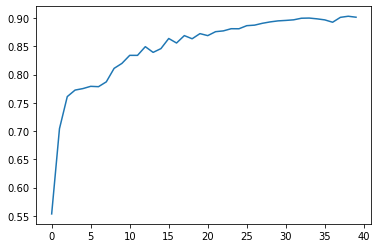

In [47]:
epochs = [i for i in range(num_epochs)]

plt.figure()
plt.plot(epochs, performances)
plt.show()



## Test Basic Active Learning on this model

In [8]:
tester = Tester([x_main, x_secondary], y)
tester.INITIAL_TRAIN_DATA_FRACTION = 0.05
tester.ACTIVE_LEARNING_BATCH_SIZE = 256
tester.TRAINING_EPOCHS = 4
tester.TEST_REPEAT_COUNT = 2

Test 1: Data size 2512: : 100%|██████████| 10/10 [05:13<00:00, 31.31s/it, data_size=2512, test_acc=0.665, train_acc=0.651]


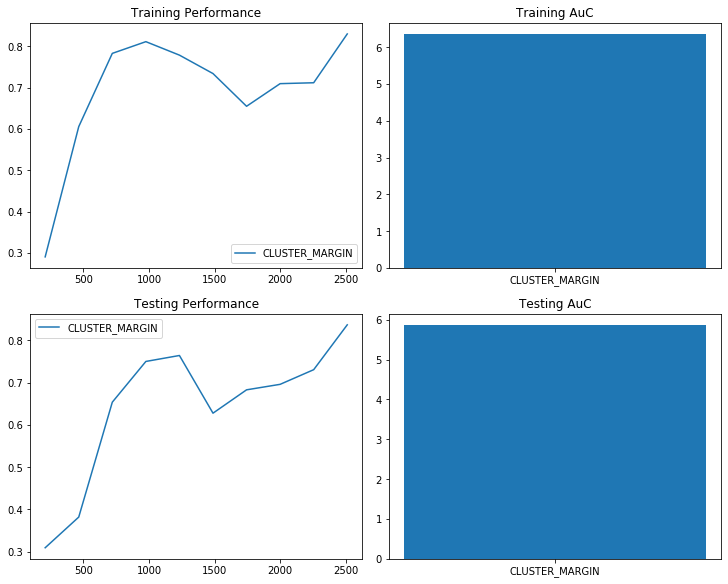

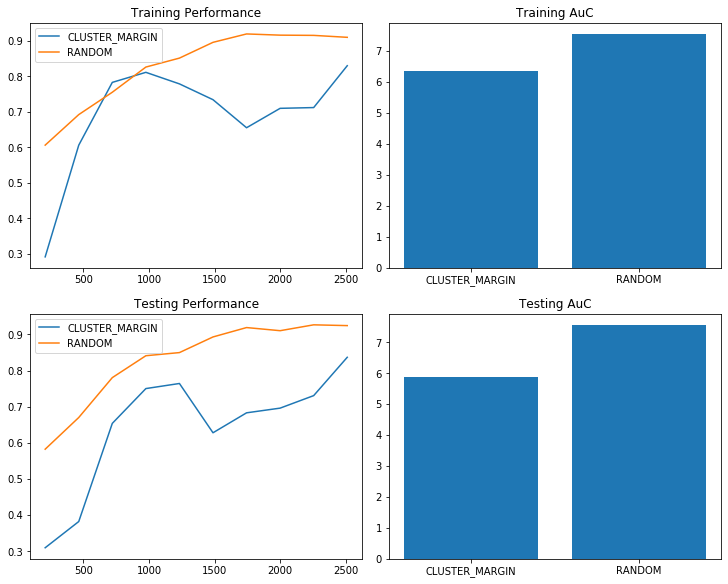

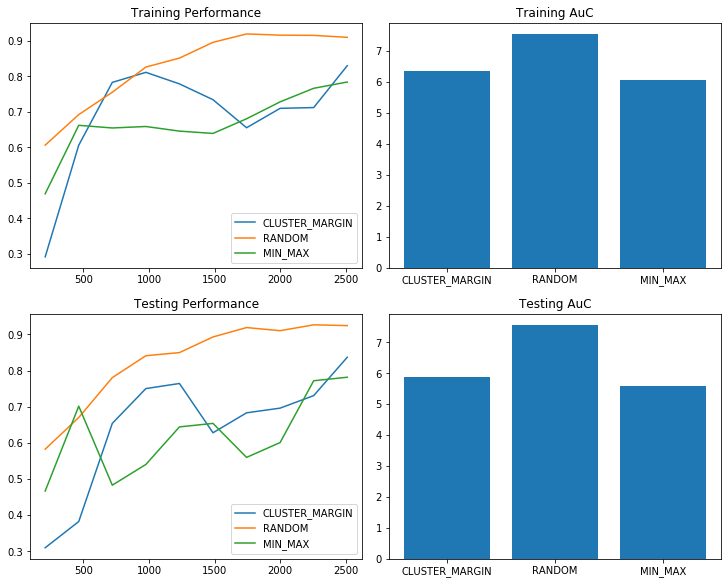

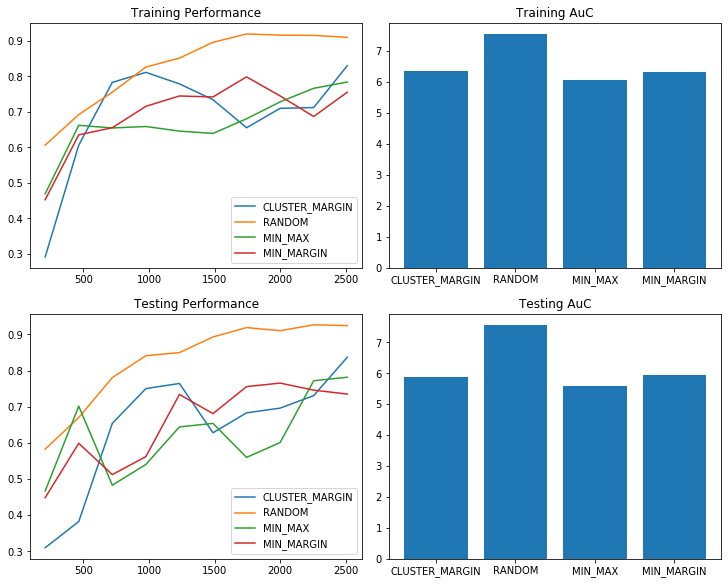

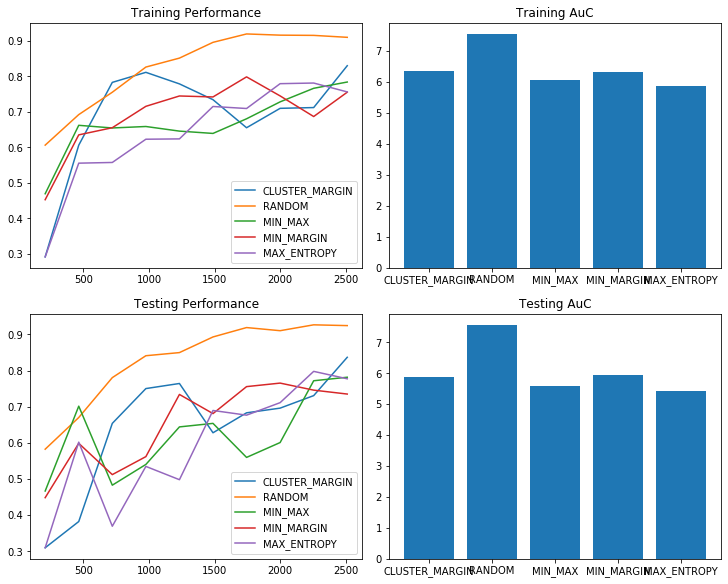

In [9]:
tester.test_model(MultiModalLateFusionModelInterface("CLUSTER_MARGIN", tester.ACTIVE_LEARNING_BATCH_SIZE))
tester.plot_results(plot_savename="test_2_results.png")
tester.test_model(MultiModalLateFusionModelInterface("RANDOM"))
tester.plot_results()
tester.test_model(MultiModalLateFusionModelInterface("MIN_MAX"))
tester.plot_results()
tester.test_model(MultiModalLateFusionModelInterface("MIN_MARGIN"))
tester.plot_results()
tester.test_model(MultiModalLateFusionModelInterface("MAX_ENTROPY"))
tester.plot_results()

## Investigating Gradient Embeddings

  0%|          | 0/10 [00:00<?, ?it/s]

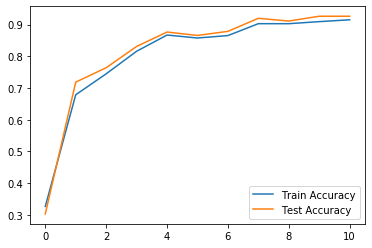

In [10]:
model_interface = MultiModalLateFusionModelInterface("CLUSTER_MARGIN")

# Train on some part of the data
labeled_size = round(0.9 * len(x_main))
x_main_labeled = x_main[:labeled_size]
x_secondary_labeled = x_secondary[:labeled_size]
y_labeled = y[:labeled_size]
x_main_unlabeled = x_main[labeled_size:]
x_secondary_unlabeled = x_secondary[labeled_size:]
y_unlabeled = y[labeled_size:]

# Log training as sanity check
train_accuracy_curve = []
test_accuracy_curve = []
train_acc = ACCURACY(y_labeled, model_interface.predict([x_main_labeled, x_secondary_labeled]))
test_acc = ACCURACY(y_unlabeled, model_interface.predict([x_main_unlabeled, x_secondary_unlabeled]))
train_accuracy_curve.append(train_acc)
test_accuracy_curve.append(test_acc)

epoch_count = 10
epoch_range = trange(epoch_count)
epoch_range.set_postfix(train_acc=train_acc, test_acc=test_acc)
for epoch in epoch_range:
    model_interface.train([x_main_labeled, x_secondary_labeled], y_labeled)

    train_acc = ACCURACY(y_labeled, model_interface.predict([x_main_labeled, x_secondary_labeled]))
    test_acc = ACCURACY(y_unlabeled, model_interface.predict([x_main_unlabeled, x_secondary_unlabeled]))
    train_accuracy_curve.append(train_acc)
    test_accuracy_curve.append(test_acc)

    epoch_range.set_postfix(train_acc=train_acc, test_acc=test_acc)

plt.plot(train_accuracy_curve, label="Train Accuracy")
plt.plot(test_accuracy_curve, label="Test Accuracy")
plt.legend()
plt.show()

In [11]:
embeddings_labeled, embedding_ind_to_param_ind = compute_gradient_embeddings(model_interface.model, [model_interface.model.post_fusion_layer.weight], [x_main_labeled, x_secondary_labeled])

In [14]:
# get the gradient embeddings for the two 
print(embeddings_labeled.shape)
print(embedding_ind_to_param_ind)

(4162, 256)
[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 0, 8], [0, 0, 9], [0, 0, 10], [0, 0, 11], [0, 0, 12], [0, 0, 13], [0, 0, 14], [0, 0, 15], [0, 0, 16], [0, 0, 17], [0, 0, 18], [0, 0, 19], [0, 0, 20], [0, 0, 21], [0, 0, 22], [0, 0, 23], [0, 0, 24], [0, 0, 25], [0, 0, 26], [0, 0, 27], [0, 0, 28], [0, 0, 29], [0, 0, 30], [0, 0, 31], [0, 0, 32], [0, 0, 33], [0, 0, 34], [0, 0, 35], [0, 0, 36], [0, 0, 37], [0, 0, 38], [0, 0, 39], [0, 0, 40], [0, 0, 41], [0, 0, 42], [0, 0, 43], [0, 0, 44], [0, 0, 45], [0, 0, 46], [0, 0, 47], [0, 0, 48], [0, 0, 49], [0, 0, 50], [0, 0, 51], [0, 0, 52], [0, 0, 53], [0, 0, 54], [0, 0, 55], [0, 0, 56], [0, 0, 57], [0, 0, 58], [0, 0, 59], [0, 0, 60], [0, 0, 61], [0, 0, 62], [0, 0, 63], [0, 1, 0], [0, 1, 1], [0, 1, 2], [0, 1, 3], [0, 1, 4], [0, 1, 5], [0, 1, 6], [0, 1, 7], [0, 1, 8], [0, 1, 9], [0, 1, 10], [0, 1, 11], [0, 1, 12], [0, 1, 13], [0, 1, 14], [0, 1, 15], [0, 1, 16], [0, 1, 17], [0, 1, 18], [0, 1, 19],

In [16]:
model_interface.model.post_fusion_layer.weight.shape

torch.Size([4, 64])

In [18]:
embedding_ind_to_param_ind = np.array(embedding_ind_to_param_ind)
first_modality_embeddings=None
#for i in range(embeddings_labeled.shape[0]):

np.unravel_index(np.arange(31), model_interface.model.post_fusion_layer.weight.shape)

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]))

In [20]:
test = torch.rand((4,64))
test

tensor([[0.7560, 0.0786, 0.4153, 0.0480, 0.4294, 0.3445, 0.0961, 0.3409, 0.0284,
         0.9208, 0.0543, 0.9619, 0.7768, 0.5987, 0.6826, 0.6250, 0.1752, 0.9133,
         0.3529, 0.5023, 0.7328, 0.9471, 0.3438, 0.2217, 0.5303, 0.6467, 0.8911,
         0.7792, 0.8315, 0.0735, 0.4339, 0.2830, 0.0491, 0.9680, 0.8790, 0.1747,
         0.7181, 0.5479, 0.2866, 0.3374, 0.3439, 0.0388, 0.4281, 0.9844, 0.2667,
         0.0821, 0.2218, 0.9577, 0.6100, 0.5768, 0.8414, 0.8140, 0.2949, 0.2876,
         0.0263, 0.3976, 0.9141, 0.6250, 0.5181, 0.8677, 0.4046, 0.1058, 0.1224,
         0.8964],
        [0.6182, 0.6686, 0.4921, 0.7660, 0.0580, 0.2187, 0.4134, 0.0060, 0.9159,
         0.1074, 0.2609, 0.6649, 0.4430, 0.1460, 0.6818, 0.2334, 0.8237, 0.0179,
         0.4237, 0.9068, 0.8574, 0.9332, 0.2365, 0.1452, 0.3028, 0.3260, 0.4431,
         0.4569, 0.0188, 0.2803, 0.2246, 0.0712, 0.9670, 0.4286, 0.8368, 0.7727,
         0.6463, 0.9327, 0.3415, 0.0893, 0.6690, 0.0841, 0.9611, 0.7589, 0.2409,
         0

In [24]:
test[:, np.arange(31)]

tensor([[0.7560, 0.0786, 0.4153, 0.0480, 0.4294, 0.3445, 0.0961, 0.3409, 0.0284,
         0.9208, 0.0543, 0.9619, 0.7768, 0.5987, 0.6826, 0.6250, 0.1752, 0.9133,
         0.3529, 0.5023, 0.7328, 0.9471, 0.3438, 0.2217, 0.5303, 0.6467, 0.8911,
         0.7792, 0.8315, 0.0735, 0.4339],
        [0.6182, 0.6686, 0.4921, 0.7660, 0.0580, 0.2187, 0.4134, 0.0060, 0.9159,
         0.1074, 0.2609, 0.6649, 0.4430, 0.1460, 0.6818, 0.2334, 0.8237, 0.0179,
         0.4237, 0.9068, 0.8574, 0.9332, 0.2365, 0.1452, 0.3028, 0.3260, 0.4431,
         0.4569, 0.0188, 0.2803, 0.2246],
        [0.7951, 0.1576, 0.2982, 0.4517, 0.7303, 0.3118, 0.1872, 0.2519, 0.6303,
         0.2036, 0.6396, 0.3591, 0.9319, 0.6772, 0.8658, 0.0499, 0.5405, 0.4895,
         0.8659, 0.6550, 0.0873, 0.8274, 0.7525, 0.0630, 0.3761, 0.6132, 0.3391,
         0.2440, 0.0837, 0.0637, 0.7015],
        [0.9771, 0.1683, 0.8923, 0.8454, 0.5574, 0.0137, 0.7592, 0.4708, 0.5579,
         0.0671, 0.7088, 0.4981, 0.4769, 0.2657, 0.4458, 0.1280,

In [34]:
#test2 = np.concatenate((np.arange(4).reshape(-1,1), np.arange(31).reshape(-1,1)), axis=1)
#print(test2)
#np.ravel_multi_index(test2, (4,64))

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4 and the array at index 1 has size 31

In [44]:
first_modality_index_combinations = np.array(np.meshgrid(np.arange(3),np.arange(31))).T.reshape(-1,2)
second_modality_index_combinations = np.array(np.meshgrid(np.arange(4),np.arange(32)+31)).T.reshape(-1,2)
#print(second_modality_index_combinations)
#print(first_modality_index_combinations.shape)
#np.ravel_multi_index(first_modality_index_combinations, (4,64))
print(first_modality_index_combinations)

[[ 0  0]
 [ 0  1]
 [ 0  2]
 [ 0  3]
 [ 0  4]
 [ 0  5]
 [ 0  6]
 [ 0  7]
 [ 0  8]
 [ 0  9]
 [ 0 10]
 [ 0 11]
 [ 0 12]
 [ 0 13]
 [ 0 14]
 [ 0 15]
 [ 0 16]
 [ 0 17]
 [ 0 18]
 [ 0 19]
 [ 0 20]
 [ 0 21]
 [ 0 22]
 [ 0 23]
 [ 0 24]
 [ 0 25]
 [ 0 26]
 [ 0 27]
 [ 0 28]
 [ 0 29]
 [ 0 30]
 [ 1  0]
 [ 1  1]
 [ 1  2]
 [ 1  3]
 [ 1  4]
 [ 1  5]
 [ 1  6]
 [ 1  7]
 [ 1  8]
 [ 1  9]
 [ 1 10]
 [ 1 11]
 [ 1 12]
 [ 1 13]
 [ 1 14]
 [ 1 15]
 [ 1 16]
 [ 1 17]
 [ 1 18]
 [ 1 19]
 [ 1 20]
 [ 1 21]
 [ 1 22]
 [ 1 23]
 [ 1 24]
 [ 1 25]
 [ 1 26]
 [ 1 27]
 [ 1 28]
 [ 1 29]
 [ 1 30]
 [ 2  0]
 [ 2  1]
 [ 2  2]
 [ 2  3]
 [ 2  4]
 [ 2  5]
 [ 2  6]
 [ 2  7]
 [ 2  8]
 [ 2  9]
 [ 2 10]
 [ 2 11]
 [ 2 12]
 [ 2 13]
 [ 2 14]
 [ 2 15]
 [ 2 16]
 [ 2 17]
 [ 2 18]
 [ 2 19]
 [ 2 20]
 [ 2 21]
 [ 2 22]
 [ 2 23]
 [ 2 24]
 [ 2 25]
 [ 2 26]
 [ 2 27]
 [ 2 28]
 [ 2 29]
 [ 2 30]]


## Get performance vs epoch number for each active learning loop iteration

In [35]:
from test_framework.metrics import LABEL_BALANCED_ACCURACY

from typing import List
import numpy as np
from tqdm.notebook import trange as trange
import matplotlib.pyplot as plt
import numpy as np
from typing import List
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import time
import sklearn.metrics as skm

from test_framework.model_interface import ModelInterface
import test_framework.metrics as metrics

class Tester:
    '''
    Args:
        x_data ([np.ndarray]):  List of required input modes. Each element of list is a numpy array with its first axis as
                                batch, and all other axes will be untouched and passed directly to models for training,
                                 testing and querying. Each element is assumed to have the same first axis length.
        y_data (np.ndarray):    The full set of dataset outputs. First axis is batch, other axes will be untouched
                                and sent to loss function as is.
    '''
    def __init__(self, x_data:List[np.ndarray], y_data:np.ndarray, training_epochs=10, active_learning_loop_count=10) -> None:
        '''
        --- Default Config ---
        '''

        # Function to call to measure performance (may change for different data formats)
        # Must be consistent for all models compared.
        self.METRIC_FUNCTION = LABEL_BALANCED_ACCURACY

        # Fraction of input data to set aside for testing
        self.TEST_DATA_FRACTION = 0.1

        # Number of times to repeat the entire testing process
        # (active learning from start to finish with different initial data)
        self.TEST_REPEAT_COUNT = 1

        # Fraction of training data each model is given to start with (before querying)
        self.INITIAL_TRAIN_DATA_FRACTION = 0.5

        # Number of active learning loops (train, query, repeat) in one test
        self.ACTIVE_LEARNING_LOOP_COUNT = active_learning_loop_count

        # Number of training epochs each model gets in each active learning loop
        self.TRAINING_EPOCHS = training_epochs

        # Number of samples added to training data in each active learning loop
        self.ACTIVE_LEARNING_BATCH_SIZE = 32


        '''
        --- State Variables ---
        '''

        # Store evaluation info (ModelResults) for each ModelInterface object tested
        self.model_results = []



        '''
        --- Data Setup ---
        '''

        # Store original data
        self.x_data = x_data
        self.y_data = y_data

        # Save shuffled data ordering for each test repeat planned
        self.data_orderings = []
        for _ in range(self.TEST_REPEAT_COUNT):
            order = np.random.permutation(self.x_data[0].shape[0])
            self.data_orderings.append(order)


    
    '''
    Performs active learning tests on the given model, storing both the model and evaluation results.
    Args:
        model (ModelInterface): The model to test (wrapped in the model interface).
    '''
    def test_model(self, model:ModelInterface) -> None:
        results = ModelResults(model, self.TEST_REPEAT_COUNT, self.ACTIVE_LEARNING_LOOP_COUNT)

        # Ensure we have enough data orderings for the test
        if len(self.data_orderings) < self.TEST_REPEAT_COUNT:
            for _ in range(self.TEST_REPEAT_COUNT - len(self.data_orderings)):
                order = np.random.permutation(self.x_data[0].shape[0])
                self.data_orderings.append(order)

        for test in range(self.TEST_REPEAT_COUNT):
            # Reset model if there are multiple tests
            if test > 0:
                model.reset()

            # Shuffle data and split into initial train data, 'unlabeled' train data, and test data.
            shuffled_x_data = [
                x_mode[self.data_orderings[test]]
                for x_mode in self.x_data
            ]
            shuffled_y_data = self.y_data[self.data_orderings[test]]

            data_size = self.x_data[0].shape[0]
            test_data_size = round(data_size * self.TEST_DATA_FRACTION)
            initial_train_data_size = round((data_size - test_data_size) * self.INITIAL_TRAIN_DATA_FRACTION)

            test_x = [
                shuffled_x_mode[:test_data_size]
                for shuffled_x_mode in shuffled_x_data
            ]
            test_y = shuffled_y_data[:test_data_size]
            train_x = [
                shuffled_x_mode[test_data_size : test_data_size + initial_train_data_size]
                for shuffled_x_mode in shuffled_x_data
            ]
            train_y = shuffled_y_data[test_data_size : test_data_size + initial_train_data_size]
            unlabeled_x = [
                shuffled_x_mode[test_data_size + initial_train_data_size :]
                for shuffled_x_mode in shuffled_x_data
            ]
            unlabeled_y = shuffled_y_data[test_data_size + initial_train_data_size :]

            # Ensure we won't attempt to label more data than we have available
            if self.ACTIVE_LEARNING_BATCH_SIZE * self.ACTIVE_LEARNING_LOOP_COUNT > len(unlabeled_y):
                raise ValueError(f"Too few unlabeled datapoints ({len(unlabeled_y)}), compared to minimum ({self.ACTIVE_LEARNING_BATCH_SIZE * self.ACTIVE_LEARNING_LOOP_COUNT}).")

            # Begin Active Learning Loops
            al_loop_range = trange(self.ACTIVE_LEARNING_LOOP_COUNT)
            al_loop_range.set_description(f"Test {test}")
            for al_loop in al_loop_range:
                print("in al_loop {}".format(al_loop))
                # Train Model on current training data
                pre_train_time = time.time()
                al_loop_range.set_description(f"Test {test}: Data size {train_x[0].shape[0]}: ")

                # Trigger training epoch
                RESULTS_PER_EPOCH = list()
                for epoch in range(self.TRAINING_EPOCHS):
                    print("in epoch {}".format(epoch))
                    shuffle_order = np.random.permutation(len(train_y))
                    shuffled_y = train_y[shuffle_order]
                    shuffled_x = [
                        x_mode[shuffle_order]
                        for x_mode in train_x
                    ]
                    model.train(shuffled_x, shuffled_y)
                    RESULTS_PER_EPOCH.append(self.METRIC_FUNCTION(train_y, model.predict(train_x)))
                training_time = time.time() - pre_train_time
                
                plt.figure()
                plt.plot([i for i in range(self.TRAINING_EPOCHS)], RESULTS_PER_EPOCH)
                plt.show()
                # plt.clf()

                # Query model for samples to label
                pre_query_time = time.time()
                label_indices = model.query(unlabeled_x, self.ACTIVE_LEARNING_BATCH_SIZE)
                querying_time = time.time() - pre_query_time

                # Evaluate model on train and test data
                train_performance = self.METRIC_FUNCTION(train_y, model.predict(train_x))
                test_performance = self.METRIC_FUNCTION(test_y, model.predict(test_x))

                # Display current performance in progressbar
                al_loop_range.set_postfix(data_size=len(train_x[0]), train_acc=train_performance, test_acc=test_performance)

                # Save model results for this active learning loop
                results.add(test, al_loop, len(train_x[0]), train_performance, test_performance, training_time, querying_time)

                # Add chosen samples to train data for next AL loop
                train_x = [
                    np.concatenate([train_x[mode_ind], unlabeled_x[mode_ind][label_indices]], axis=0)
                    for mode_ind in range(len(train_x))
                ]
                train_y = np.concatenate([train_y, unlabeled_y[label_indices]], axis=0)
                unlabeled_x = [
                    np.delete(unlabeled_x_mode, label_indices, axis=0)
                    for unlabeled_x_mode in unlabeled_x
                ]
                unlabeled_y = np.delete(unlabeled_y, label_indices, axis=0)

        # Save results
        self.model_results.append(results)



    '''
    Plots and saves train/test curves for all models, along with their AUC measures
    '''
    def plot_results(self, plot_savename="test_results.png", show=False) -> None:
        fig, axarr = plt.subplots(2, 2, figsize=(10,8), constrained_layout=True)

        model_names = [r.model_name for r in self.model_results]

        # Plot training curve
        for r in self.model_results:
            x = np.mean(r.data_size, axis=0)
            y = np.mean(r.training_performance, axis=0)
            axarr[0][0].plot(x, y, label=r.model_name)
        axarr[0][0].legend()
        axarr[0][0].title.set_text("Training Performance")

        # Plot train AuC measure for each model
        train_auc = []
        for r in self.model_results:
            y = np.mean(r.training_performance, axis=0)
            train_auc.append(skm.auc(range(self.ACTIVE_LEARNING_LOOP_COUNT), y))
        axarr[0][1].bar(model_names, train_auc)
        axarr[0][1].title.set_text("Training AuC")

        # Plot testing curve
        for r in self.model_results:
            x = np.mean(r.data_size, axis=0)
            y = np.mean(r.test_performance, axis=0)
            axarr[1][0].plot(x, y, label=r.model_name)
        axarr[1][0].legend()
        axarr[1][0].title.set_text("Testing Performance")

        # Plot test AuC measure for each model
        test_auc = []
        for r in self.model_results:
            y = np.mean(r.test_performance, axis=0)
            test_auc.append(skm.auc(range(self.ACTIVE_LEARNING_LOOP_COUNT), y))
        axarr[1][1].bar(model_names, test_auc)
        axarr[1][1].title.set_text("Testing AuC")

        # Save plots
        plt.savefig(plot_savename, facecolor='white', transparent=False)
        if show:
            plt.show()

            
            '''
Simple struct for Tester to store evaluation info associated with a particular model
'''
class ModelResults:
    def __init__(self, model:ModelInterface, test_count: int, active_learning_loop_count: int):
        # Store name and details to identify model and results if model is lost
        self.model_name = model.name()
        self.model_details = model.details()

        # Store data size after each active learning loop
        self.data_size = np.zeros((test_count, active_learning_loop_count))

        # Store performance on training and test data after each active learning loop
        self.training_performance = np.zeros((test_count, active_learning_loop_count))
        self.test_performance = np.zeros((test_count, active_learning_loop_count))

        # Store training time during each active learning loop
        self.training_time = np.zeros((test_count, active_learning_loop_count))

        # Store querying time during each active learning loop
        self.querying_time = np.zeros((test_count, active_learning_loop_count))

    def add(self, test_iteration, active_learning_iteration, data_size, training_performance, test_performance, training_time, querying_time):
        self.data_size[test_iteration, active_learning_iteration] = data_size
        self.training_performance[test_iteration, active_learning_iteration] = training_performance
        self.test_performance[test_iteration, active_learning_iteration] = test_performance
        self.training_time[test_iteration, active_learning_iteration] = training_time
        self.querying_time[test_iteration, active_learning_iteration] = querying_time


In [36]:
tester = Tester([x_main, x_secondary], y)
tester.INITIAL_TRAIN_DATA_FRACTION = 0.05
tester.ACTIVE_LEARNING_BATCH_SIZE = 32
tester.TRAINING_EPOCHS = 40
#tester.TRAINING_EPOCHS = 2
tester.TEST_REPEAT_COUNT = 2

Test 0: Data size 208: :   0%|          | 0/10 [00:00<?, ?it/s]

in al_loop 0
in epoch 0
in epoch 1
in epoch 2
in epoch 3
in epoch 4
in epoch 5
in epoch 6
in epoch 7
in epoch 8
in epoch 9
in epoch 10
in epoch 11
in epoch 12
in epoch 13
in epoch 14
in epoch 15
in epoch 16
in epoch 17
in epoch 18
in epoch 19
in epoch 20
in epoch 21
in epoch 22
in epoch 23
in epoch 24
in epoch 25
in epoch 26
in epoch 27
in epoch 28
in epoch 29
in epoch 30
in epoch 31
in epoch 32
in epoch 33
in epoch 34
in epoch 35
in epoch 36
in epoch 37
in epoch 38
in epoch 39


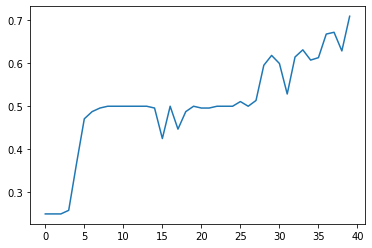

Test 0: Data size 240: :  10%|█         | 1/10 [00:40<06:04, 40.45s/it, data_size=208, test_acc=0.705, train_acc=0.709]

in al_loop 1
in epoch 0
in epoch 1
in epoch 2
in epoch 3
in epoch 4
in epoch 5
in epoch 6
in epoch 7
in epoch 8
in epoch 9
in epoch 10
in epoch 11
in epoch 12
in epoch 13
in epoch 14
in epoch 15
in epoch 16
in epoch 17
in epoch 18
in epoch 19
in epoch 20
in epoch 21
in epoch 22
in epoch 23
in epoch 24
in epoch 25
in epoch 26
in epoch 27
in epoch 28
in epoch 29
in epoch 30
in epoch 31
in epoch 32
in epoch 33
in epoch 34
in epoch 35
in epoch 36
in epoch 37
in epoch 38
in epoch 39


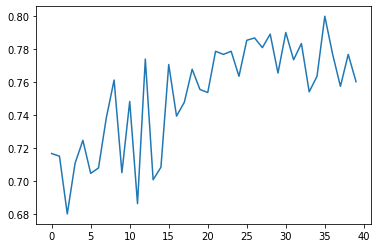

Test 0: Data size 272: :  20%|██        | 2/10 [01:22<05:31, 41.46s/it, data_size=240, test_acc=0.742, train_acc=0.76] 

in al_loop 2
in epoch 0
in epoch 1
in epoch 2
in epoch 3
in epoch 4
in epoch 5
in epoch 6
in epoch 7
in epoch 8
in epoch 9
in epoch 10
in epoch 11
in epoch 12
in epoch 13
in epoch 14
in epoch 15
in epoch 16
in epoch 17
in epoch 18
in epoch 19
in epoch 20
in epoch 21
in epoch 22
in epoch 23
in epoch 24
in epoch 25
in epoch 26
in epoch 27
in epoch 28
in epoch 29
in epoch 30
in epoch 31
in epoch 32
in epoch 33
in epoch 34
in epoch 35
in epoch 36
in epoch 37
in epoch 38
in epoch 39


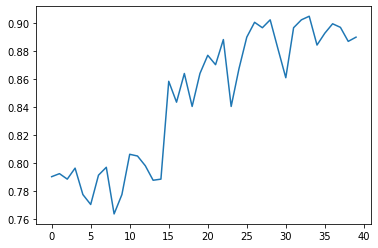

Test 0: Data size 304: :  30%|███       | 3/10 [02:33<06:23, 54.83s/it, data_size=272, test_acc=0.859, train_acc=0.89]

in al_loop 3
in epoch 0
in epoch 1
in epoch 2
in epoch 3
in epoch 4
in epoch 5
in epoch 6
in epoch 7
in epoch 8
in epoch 9
in epoch 10
in epoch 11
in epoch 12
in epoch 13
in epoch 14
in epoch 15
in epoch 16
in epoch 17
in epoch 18
in epoch 19
in epoch 20
in epoch 21
in epoch 22
in epoch 23
in epoch 24
in epoch 25
in epoch 26
in epoch 27
in epoch 28
in epoch 29
in epoch 30
in epoch 31
in epoch 32
in epoch 33
in epoch 34
in epoch 35
in epoch 36
in epoch 37
in epoch 38
in epoch 39


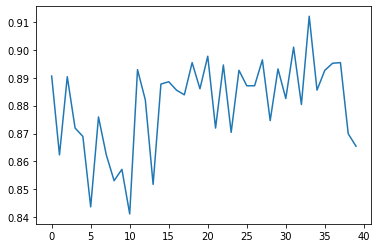

Test 0: Data size 336: :  40%|████      | 4/10 [03:46<06:12, 62.02s/it, data_size=304, test_acc=0.854, train_acc=0.865]

in al_loop 4
in epoch 0
in epoch 1
in epoch 2
in epoch 3
in epoch 4
in epoch 5
in epoch 6
in epoch 7
in epoch 8
in epoch 9
in epoch 10
in epoch 11
in epoch 12
in epoch 13
in epoch 14
in epoch 15
in epoch 16
in epoch 17
in epoch 18
in epoch 19
in epoch 20
in epoch 21
in epoch 22
in epoch 23
in epoch 24
in epoch 25
in epoch 26
in epoch 27
in epoch 28
in epoch 29
in epoch 30
in epoch 31
in epoch 32
in epoch 33
in epoch 34
in epoch 35
in epoch 36
in epoch 37
in epoch 38
in epoch 39


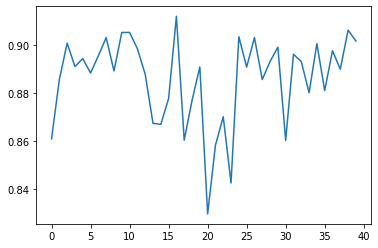

Test 0: Data size 368: :  50%|█████     | 5/10 [04:59<05:30, 66.16s/it, data_size=336, test_acc=0.919, train_acc=0.902]

in al_loop 5
in epoch 0
in epoch 1
in epoch 2
in epoch 3
in epoch 4
in epoch 5
in epoch 6
in epoch 7
in epoch 8
in epoch 9
in epoch 10
in epoch 11
in epoch 12
in epoch 13
in epoch 14
in epoch 15
in epoch 16
in epoch 17
in epoch 18
in epoch 19
in epoch 20
in epoch 21
in epoch 22
in epoch 23
in epoch 24
in epoch 25
in epoch 26
in epoch 27
in epoch 28
in epoch 29
in epoch 30
in epoch 31
in epoch 32
in epoch 33
in epoch 34
in epoch 35
in epoch 36
in epoch 37
in epoch 38
in epoch 39


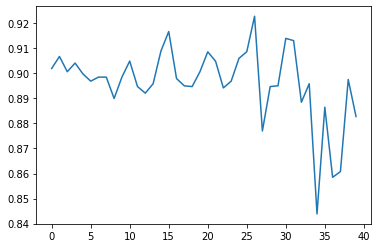

Test 0: Data size 400: :  60%|██████    | 6/10 [06:14<04:36, 69.05s/it, data_size=368, test_acc=0.861, train_acc=0.883]

in al_loop 6
in epoch 0
in epoch 1
in epoch 2
in epoch 3
in epoch 4
in epoch 5
in epoch 6
in epoch 7
in epoch 8
in epoch 9
in epoch 10
in epoch 11
in epoch 12
in epoch 13
in epoch 14
in epoch 15
in epoch 16
in epoch 17
in epoch 18
in epoch 19
in epoch 20
in epoch 21
in epoch 22
in epoch 23
in epoch 24
in epoch 25
in epoch 26
in epoch 27
in epoch 28
in epoch 29
in epoch 30
in epoch 31
in epoch 32
in epoch 33
in epoch 34
in epoch 35
in epoch 36
in epoch 37
in epoch 38
in epoch 39


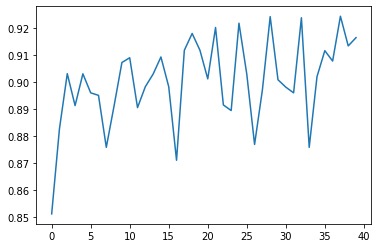

Test 0: Data size 432: :  70%|███████   | 7/10 [07:58<04:01, 80.62s/it, data_size=400, test_acc=0.902, train_acc=0.916]

in al_loop 7
in epoch 0
in epoch 1
in epoch 2
in epoch 3
in epoch 4
in epoch 5
in epoch 6
in epoch 7
in epoch 8
in epoch 9
in epoch 10
in epoch 11
in epoch 12
in epoch 13
in epoch 14
in epoch 15
in epoch 16
in epoch 17
in epoch 18
in epoch 19
in epoch 20
in epoch 21
in epoch 22
in epoch 23
in epoch 24
in epoch 25
in epoch 26
in epoch 27
in epoch 28
in epoch 29
in epoch 30
in epoch 31
in epoch 32
in epoch 33
in epoch 34
in epoch 35
in epoch 36
in epoch 37
in epoch 38
in epoch 39


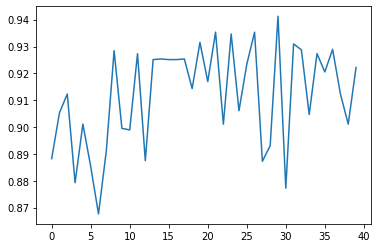

Test 0: Data size 464: :  80%|████████  | 8/10 [09:44<02:56, 88.44s/it, data_size=432, test_acc=0.912, train_acc=0.922]

in al_loop 8
in epoch 0
in epoch 1
in epoch 2
in epoch 3
in epoch 4
in epoch 5
in epoch 6
in epoch 7
in epoch 8
in epoch 9
in epoch 10
in epoch 11
in epoch 12
in epoch 13
in epoch 14
in epoch 15
in epoch 16
in epoch 17
in epoch 18
in epoch 19
in epoch 20
in epoch 21
in epoch 22
in epoch 23
in epoch 24
in epoch 25
in epoch 26
in epoch 27
in epoch 28
in epoch 29
in epoch 30
in epoch 31
in epoch 32
in epoch 33
in epoch 34
in epoch 35
in epoch 36
in epoch 37
in epoch 38
in epoch 39


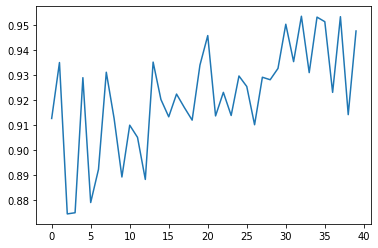

Test 0: Data size 496: :  90%|█████████ | 9/10 [11:30<01:33, 93.95s/it, data_size=464, test_acc=0.922, train_acc=0.948]

in al_loop 9
in epoch 0
in epoch 1
in epoch 2
in epoch 3
in epoch 4
in epoch 5
in epoch 6
in epoch 7
in epoch 8
in epoch 9
in epoch 10
in epoch 11
in epoch 12
in epoch 13
in epoch 14
in epoch 15
in epoch 16
in epoch 17
in epoch 18
in epoch 19
in epoch 20
in epoch 21
in epoch 22
in epoch 23
in epoch 24
in epoch 25
in epoch 26
in epoch 27
in epoch 28
in epoch 29
in epoch 30
in epoch 31
in epoch 32
in epoch 33
in epoch 34
in epoch 35
in epoch 36
in epoch 37
in epoch 38
in epoch 39


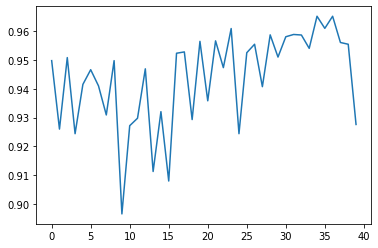

Test 1: Data size 208: :   0%|          | 0/10 [00:00<?, ?it/s]

in al_loop 0
in epoch 0
in epoch 1
in epoch 2
in epoch 3
in epoch 4
in epoch 5
in epoch 6
in epoch 7
in epoch 8
in epoch 9
in epoch 10
in epoch 11
in epoch 12
in epoch 13
in epoch 14
in epoch 15
in epoch 16
in epoch 17
in epoch 18
in epoch 19
in epoch 20
in epoch 21
in epoch 22
in epoch 23
in epoch 24
in epoch 25
in epoch 26
in epoch 27
in epoch 28
in epoch 29
in epoch 30
in epoch 31
in epoch 32
in epoch 33
in epoch 34
in epoch 35
in epoch 36
in epoch 37
in epoch 38
in epoch 39


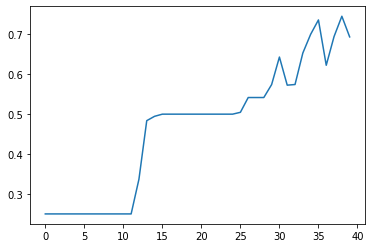

Test 1: Data size 240: :  10%|█         | 1/10 [00:42<06:19, 42.11s/it, data_size=208, test_acc=0.669, train_acc=0.694]

in al_loop 1
in epoch 0
in epoch 1
in epoch 2
in epoch 3
in epoch 4
in epoch 5
in epoch 6
in epoch 7
in epoch 8
in epoch 9
in epoch 10
in epoch 11
in epoch 12
in epoch 13
in epoch 14
in epoch 15
in epoch 16
in epoch 17
in epoch 18
in epoch 19
in epoch 20
in epoch 21
in epoch 22
in epoch 23
in epoch 24
in epoch 25
in epoch 26
in epoch 27
in epoch 28
in epoch 29
in epoch 30
in epoch 31
in epoch 32
in epoch 33
in epoch 34
in epoch 35
in epoch 36
in epoch 37
in epoch 38
in epoch 39


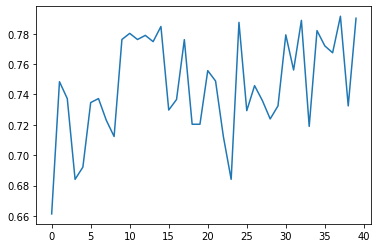

Test 1: Data size 272: :  20%|██        | 2/10 [01:25<05:42, 42.82s/it, data_size=240, test_acc=0.756, train_acc=0.79] 

in al_loop 2
in epoch 0
in epoch 1
in epoch 2
in epoch 3
in epoch 4
in epoch 5
in epoch 6
in epoch 7
in epoch 8
in epoch 9
in epoch 10
in epoch 11
in epoch 12
in epoch 13
in epoch 14
in epoch 15
in epoch 16
in epoch 17
in epoch 18
in epoch 19
in epoch 20
in epoch 21
in epoch 22
in epoch 23
in epoch 24
in epoch 25
in epoch 26
in epoch 27
in epoch 28
in epoch 29
in epoch 30
in epoch 31
in epoch 32
in epoch 33
in epoch 34
in epoch 35
in epoch 36
in epoch 37
in epoch 38
in epoch 39


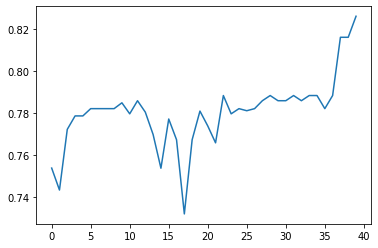

Test 1: Data size 304: :  30%|███       | 3/10 [02:36<06:30, 55.80s/it, data_size=272, test_acc=0.791, train_acc=0.826]

in al_loop 3
in epoch 0
in epoch 1
in epoch 2
in epoch 3
in epoch 4
in epoch 5
in epoch 6
in epoch 7
in epoch 8
in epoch 9
in epoch 10
in epoch 11
in epoch 12
in epoch 13
in epoch 14
in epoch 15
in epoch 16
in epoch 17
in epoch 18
in epoch 19
in epoch 20
in epoch 21
in epoch 22
in epoch 23
in epoch 24
in epoch 25
in epoch 26
in epoch 27
in epoch 28
in epoch 29
in epoch 30
in epoch 31
in epoch 32
in epoch 33
in epoch 34
in epoch 35
in epoch 36
in epoch 37
in epoch 38
in epoch 39


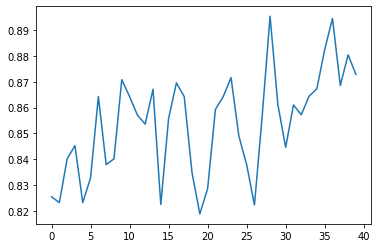

Test 1: Data size 336: :  40%|████      | 4/10 [03:49<06:16, 62.71s/it, data_size=304, test_acc=0.884, train_acc=0.873]

in al_loop 4
in epoch 0
in epoch 1
in epoch 2
in epoch 3
in epoch 4
in epoch 5
in epoch 6
in epoch 7
in epoch 8
in epoch 9
in epoch 10
in epoch 11
in epoch 12
in epoch 13
in epoch 14
in epoch 15
in epoch 16
in epoch 17
in epoch 18
in epoch 19
in epoch 20
in epoch 21
in epoch 22
in epoch 23
in epoch 24
in epoch 25
in epoch 26
in epoch 27
in epoch 28
in epoch 29
in epoch 30
in epoch 31
in epoch 32
in epoch 33
in epoch 34
in epoch 35
in epoch 36
in epoch 37
in epoch 38
in epoch 39


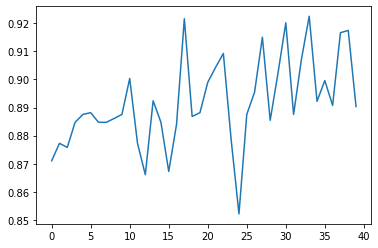

Test 1: Data size 368: :  50%|█████     | 5/10 [05:04<05:34, 66.96s/it, data_size=336, test_acc=0.89, train_acc=0.89]  

in al_loop 5
in epoch 0
in epoch 1
in epoch 2
in epoch 3
in epoch 4
in epoch 5
in epoch 6
in epoch 7
in epoch 8
in epoch 9
in epoch 10
in epoch 11
in epoch 12
in epoch 13
in epoch 14
in epoch 15
in epoch 16
in epoch 17
in epoch 18
in epoch 19
in epoch 20
in epoch 21
in epoch 22
in epoch 23
in epoch 24
in epoch 25
in epoch 26
in epoch 27
in epoch 28
in epoch 29
in epoch 30
in epoch 31
in epoch 32
in epoch 33
in epoch 34
in epoch 35
in epoch 36
in epoch 37
in epoch 38
in epoch 39


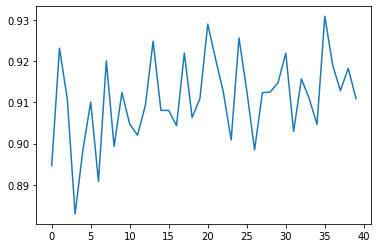

Test 1: Data size 400: :  60%|██████    | 6/10 [06:20<04:40, 70.03s/it, data_size=368, test_acc=0.91, train_acc=0.911]

in al_loop 6
in epoch 0
in epoch 1
in epoch 2
in epoch 3
in epoch 4
in epoch 5
in epoch 6
in epoch 7
in epoch 8
in epoch 9
in epoch 10
in epoch 11
in epoch 12
in epoch 13
in epoch 14
in epoch 15
in epoch 16
in epoch 17
in epoch 18
in epoch 19
in epoch 20
in epoch 21
in epoch 22
in epoch 23
in epoch 24
in epoch 25
in epoch 26
in epoch 27
in epoch 28
in epoch 29
in epoch 30
in epoch 31
in epoch 32
in epoch 33
in epoch 34
in epoch 35
in epoch 36
in epoch 37
in epoch 38
in epoch 39


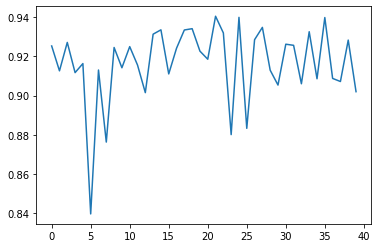

Test 1: Data size 432: :  70%|███████   | 7/10 [08:04<04:03, 81.20s/it, data_size=400, test_acc=0.891, train_acc=0.902]

in al_loop 7
in epoch 0
in epoch 1
in epoch 2
in epoch 3
in epoch 4
in epoch 5
in epoch 6


Test 1: Data size 432: :  70%|███████   | 7/10 [08:21<03:34, 71.59s/it, data_size=400, test_acc=0.891, train_acc=0.902]


KeyboardInterrupt: 

In [37]:
tester.test_model(MultiModalLateFusionModelInterface("RANDOM"))


In [38]:
tester = Tester([x_main, x_secondary], y)
tester.INITIAL_TRAIN_DATA_FRACTION = 0.05
tester.ACTIVE_LEARNING_BATCH_SIZE = 64
tester.TRAINING_EPOCHS = 40
#tester.TRAINING_EPOCHS = 2
tester.TEST_REPEAT_COUNT = 2



Test 0: Data size 208: :   0%|          | 0/10 [00:00<?, ?it/s]

in al_loop 0
in epoch 0
in epoch 1
in epoch 2
in epoch 3
in epoch 4
in epoch 5
in epoch 6
in epoch 7
in epoch 8
in epoch 9
in epoch 10
in epoch 11
in epoch 12
in epoch 13
in epoch 14
in epoch 15
in epoch 16
in epoch 17
in epoch 18
in epoch 19
in epoch 20
in epoch 21
in epoch 22
in epoch 23
in epoch 24
in epoch 25
in epoch 26
in epoch 27
in epoch 28
in epoch 29
in epoch 30
in epoch 31
in epoch 32
in epoch 33
in epoch 34
in epoch 35
in epoch 36
in epoch 37
in epoch 38
in epoch 39


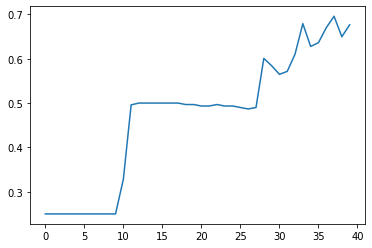

Test 0: Data size 272: :  10%|█         | 1/10 [00:40<06:07, 40.88s/it, data_size=208, test_acc=0.679, train_acc=0.677]

in al_loop 1
in epoch 0
in epoch 1
in epoch 2
in epoch 3
in epoch 4
in epoch 5
in epoch 6
in epoch 7
in epoch 8
in epoch 9
in epoch 10
in epoch 11
in epoch 12
in epoch 13
in epoch 14
in epoch 15
in epoch 16
in epoch 17
in epoch 18
in epoch 19
in epoch 20
in epoch 21
in epoch 22
in epoch 23
in epoch 24
in epoch 25
in epoch 26
in epoch 27
in epoch 28
in epoch 29
in epoch 30
in epoch 31
in epoch 32
in epoch 33
in epoch 34
in epoch 35
in epoch 36
in epoch 37
in epoch 38
in epoch 39


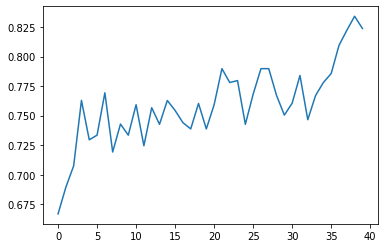

Test 0: Data size 336: :  20%|██        | 2/10 [01:50<07:42, 57.86s/it, data_size=272, test_acc=0.81, train_acc=0.824] 

in al_loop 2
in epoch 0
in epoch 1
in epoch 2
in epoch 3
in epoch 4
in epoch 5
in epoch 6
in epoch 7
in epoch 8
in epoch 9
in epoch 10
in epoch 11
in epoch 12
in epoch 13
in epoch 14
in epoch 15
in epoch 16
in epoch 17
in epoch 18
in epoch 19
in epoch 20
in epoch 21
in epoch 22
in epoch 23
in epoch 24
in epoch 25
in epoch 26
in epoch 27
in epoch 28
in epoch 29
in epoch 30
in epoch 31
in epoch 32
in epoch 33
in epoch 34
in epoch 35
in epoch 36
in epoch 37
in epoch 38
in epoch 39


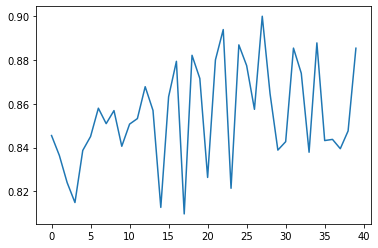

Test 0: Data size 400: :  30%|███       | 3/10 [03:02<07:30, 64.37s/it, data_size=336, test_acc=0.846, train_acc=0.885]

in al_loop 3
in epoch 0
in epoch 1
in epoch 2
in epoch 3
in epoch 4
in epoch 5
in epoch 6
in epoch 7
in epoch 8
in epoch 9
in epoch 10
in epoch 11
in epoch 12
in epoch 13
in epoch 14
in epoch 15
in epoch 16
in epoch 17
in epoch 18
in epoch 19
in epoch 20
in epoch 21
in epoch 22
in epoch 23
in epoch 24
in epoch 25
in epoch 26
in epoch 27
in epoch 28
in epoch 29
in epoch 30
in epoch 31
in epoch 32
in epoch 33
in epoch 34
in epoch 35
in epoch 36
in epoch 37
in epoch 38
in epoch 39


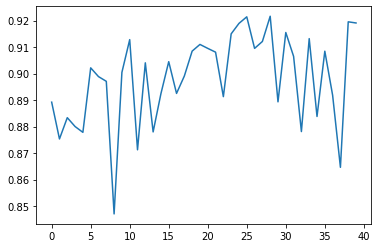

Test 0: Data size 464: :  40%|████      | 4/10 [04:43<07:52, 78.71s/it, data_size=400, test_acc=0.874, train_acc=0.919]

in al_loop 4
in epoch 0
in epoch 1
in epoch 2
in epoch 3
in epoch 4
in epoch 5
in epoch 6
in epoch 7
in epoch 8
in epoch 9
in epoch 10
in epoch 11
in epoch 12
in epoch 13
in epoch 14
in epoch 15
in epoch 16
in epoch 17
in epoch 18
in epoch 19
in epoch 20
in epoch 21
in epoch 22
in epoch 23
in epoch 24
in epoch 25
in epoch 26
in epoch 27
in epoch 28
in epoch 29
in epoch 30
in epoch 31
in epoch 32
in epoch 33
in epoch 34
in epoch 35
in epoch 36
in epoch 37
in epoch 38
in epoch 39


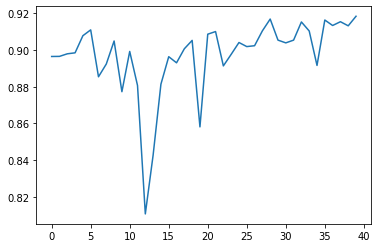

Test 0: Data size 528: :  50%|█████     | 5/10 [06:27<07:18, 87.68s/it, data_size=464, test_acc=0.887, train_acc=0.918]

in al_loop 5
in epoch 0
in epoch 1
in epoch 2
in epoch 3
in epoch 4
in epoch 5
in epoch 6
in epoch 7
in epoch 8
in epoch 9
in epoch 10
in epoch 11
in epoch 12
in epoch 13
in epoch 14
in epoch 15
in epoch 16
in epoch 17
in epoch 18
in epoch 19
in epoch 20
in epoch 21
in epoch 22
in epoch 23
in epoch 24
in epoch 25
in epoch 26
in epoch 27
in epoch 28
in epoch 29
in epoch 30
in epoch 31
in epoch 32
in epoch 33
in epoch 34
in epoch 35
in epoch 36
in epoch 37
in epoch 38
in epoch 39


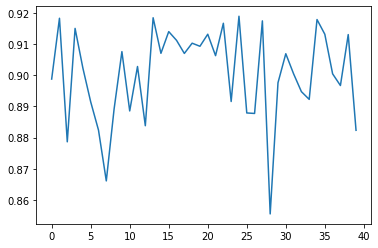

Test 0: Data size 592: :  60%|██████    | 6/10 [08:39<06:51, 102.94s/it, data_size=528, test_acc=0.857, train_acc=0.882]

in al_loop 6
in epoch 0
in epoch 1
in epoch 2
in epoch 3
in epoch 4
in epoch 5
in epoch 6
in epoch 7
in epoch 8
in epoch 9
in epoch 10
in epoch 11
in epoch 12
in epoch 13
in epoch 14
in epoch 15
in epoch 16
in epoch 17
in epoch 18
in epoch 19
in epoch 20
in epoch 21
in epoch 22
in epoch 23
in epoch 24
in epoch 25
in epoch 26
in epoch 27
in epoch 28
in epoch 29
in epoch 30
in epoch 31
in epoch 32
in epoch 33
in epoch 34
in epoch 35
in epoch 36
in epoch 37
in epoch 38
in epoch 39


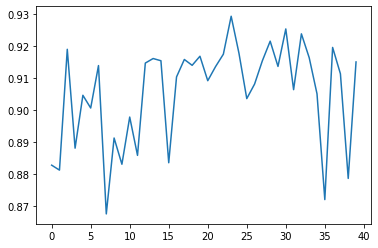

Test 0: Data size 656: :  70%|███████   | 7/10 [10:54<05:40, 113.41s/it, data_size=592, test_acc=0.888, train_acc=0.915]

in al_loop 7
in epoch 0
in epoch 1
in epoch 2
in epoch 3
in epoch 4
in epoch 5
in epoch 6
in epoch 7
in epoch 8
in epoch 9
in epoch 10
in epoch 11
in epoch 12
in epoch 13
in epoch 14
in epoch 15
in epoch 16
in epoch 17
in epoch 18
in epoch 19
in epoch 20
in epoch 21
in epoch 22
in epoch 23
in epoch 24
in epoch 25
in epoch 26
in epoch 27
in epoch 28
in epoch 29
in epoch 30
in epoch 31
in epoch 32
in epoch 33
in epoch 34
in epoch 35
in epoch 36
in epoch 37
in epoch 38
in epoch 39


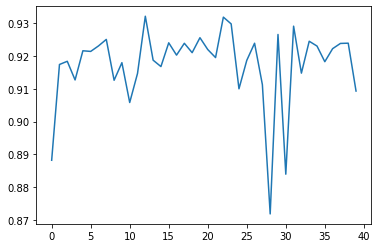

Test 0: Data size 720: :  80%|████████  | 8/10 [13:41<04:20, 130.35s/it, data_size=656, test_acc=0.861, train_acc=0.909]

in al_loop 8
in epoch 0
in epoch 1
in epoch 2
in epoch 3
in epoch 4
in epoch 5
in epoch 6
in epoch 7
in epoch 8
in epoch 9
in epoch 10
in epoch 11
in epoch 12
in epoch 13
in epoch 14
in epoch 15
in epoch 16
in epoch 17
in epoch 18
in epoch 19
in epoch 20
in epoch 21
in epoch 22
in epoch 23
in epoch 24
in epoch 25
in epoch 26
in epoch 27
in epoch 28
in epoch 29
in epoch 30
in epoch 31
in epoch 32
in epoch 33
in epoch 34
in epoch 35
in epoch 36
in epoch 37
in epoch 38
in epoch 39


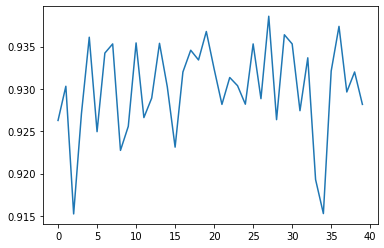

Test 0: Data size 784: :  90%|█████████ | 9/10 [16:31<02:22, 142.80s/it, data_size=720, test_acc=0.906, train_acc=0.928]

in al_loop 9
in epoch 0
in epoch 1
in epoch 2
in epoch 3
in epoch 4
in epoch 5
in epoch 6
in epoch 7
in epoch 8
in epoch 9
in epoch 10
in epoch 11
in epoch 12
in epoch 13
in epoch 14
in epoch 15
in epoch 16
in epoch 17
in epoch 18
in epoch 19
in epoch 20
in epoch 21
in epoch 22
in epoch 23
in epoch 24
in epoch 25
in epoch 26
in epoch 27
in epoch 28
in epoch 29
in epoch 30
in epoch 31
in epoch 32
in epoch 33
in epoch 34
in epoch 35
in epoch 36
in epoch 37
in epoch 38
in epoch 39


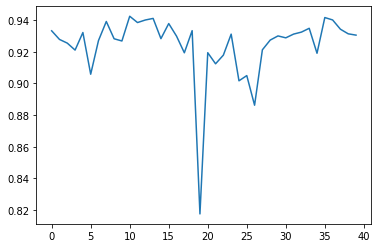

Test 1: Data size 208: :   0%|          | 0/10 [00:00<?, ?it/s]

in al_loop 0
in epoch 0
in epoch 1
in epoch 2
in epoch 3
in epoch 4
in epoch 5
in epoch 6
in epoch 7
in epoch 8
in epoch 9
in epoch 10
in epoch 11
in epoch 12
in epoch 13
in epoch 14
in epoch 15
in epoch 16
in epoch 17
in epoch 18
in epoch 19
in epoch 20
in epoch 21
in epoch 22
in epoch 23
in epoch 24
in epoch 25
in epoch 26
in epoch 27
in epoch 28
in epoch 29
in epoch 30
in epoch 31
in epoch 32
in epoch 33
in epoch 34
in epoch 35
in epoch 36
in epoch 37
in epoch 38
in epoch 39


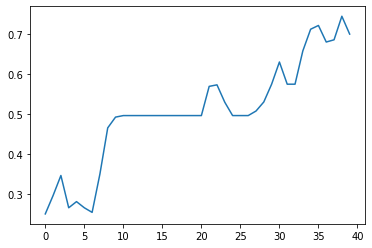

Test 1: Data size 272: :  10%|█         | 1/10 [00:41<06:16, 41.78s/it, data_size=208, test_acc=0.704, train_acc=0.7]

in al_loop 1
in epoch 0
in epoch 1
in epoch 2
in epoch 3
in epoch 4
in epoch 5
in epoch 6
in epoch 7
in epoch 8
in epoch 9
in epoch 10
in epoch 11
in epoch 12
in epoch 13
in epoch 14
in epoch 15
in epoch 16
in epoch 17
in epoch 18
in epoch 19
in epoch 20
in epoch 21
in epoch 22
in epoch 23
in epoch 24
in epoch 25
in epoch 26
in epoch 27
in epoch 28
in epoch 29
in epoch 30
in epoch 31
in epoch 32
in epoch 33
in epoch 34
in epoch 35
in epoch 36
in epoch 37
in epoch 38
in epoch 39


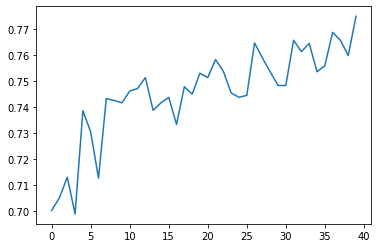

Test 1: Data size 336: :  20%|██        | 2/10 [01:54<08:00, 60.06s/it, data_size=272, test_acc=0.783, train_acc=0.775]

in al_loop 2
in epoch 0
in epoch 1
in epoch 2
in epoch 3
in epoch 4
in epoch 5
in epoch 6
in epoch 7
in epoch 8
in epoch 9
in epoch 10
in epoch 11
in epoch 12
in epoch 13
in epoch 14
in epoch 15
in epoch 16
in epoch 17
in epoch 18
in epoch 19
in epoch 20
in epoch 21
in epoch 22
in epoch 23
in epoch 24
in epoch 25
in epoch 26
in epoch 27
in epoch 28
in epoch 29
in epoch 30
in epoch 31
in epoch 32
in epoch 33
in epoch 34
in epoch 35
in epoch 36
in epoch 37
in epoch 38
in epoch 39


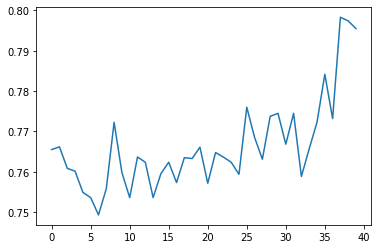

Test 1: Data size 400: :  30%|███       | 3/10 [03:10<07:51, 67.41s/it, data_size=336, test_acc=0.819, train_acc=0.795]

in al_loop 3
in epoch 0
in epoch 1
in epoch 2
in epoch 3
in epoch 4
in epoch 5
in epoch 6
in epoch 7
in epoch 8
in epoch 9
in epoch 10
in epoch 11
in epoch 12
in epoch 13
in epoch 14
in epoch 15
in epoch 16
in epoch 17
in epoch 18
in epoch 19
in epoch 20
in epoch 21
in epoch 22
in epoch 23
in epoch 24
in epoch 25
in epoch 26
in epoch 27
in epoch 28
in epoch 29
in epoch 30
in epoch 31
in epoch 32
in epoch 33
in epoch 34
in epoch 35
in epoch 36
in epoch 37
in epoch 38
in epoch 39


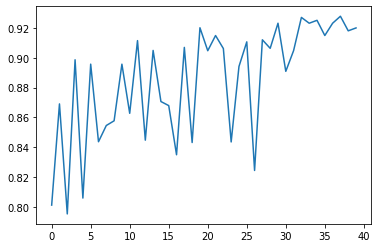

Test 1: Data size 464: :  40%|████      | 4/10 [04:58<08:19, 83.17s/it, data_size=400, test_acc=0.922, train_acc=0.92] 

in al_loop 4
in epoch 0
in epoch 1
in epoch 2
in epoch 3
in epoch 4
in epoch 5
in epoch 6
in epoch 7
in epoch 8
in epoch 9
in epoch 10
in epoch 11
in epoch 12
in epoch 13
in epoch 14
in epoch 15
in epoch 16
in epoch 17
in epoch 18
in epoch 19
in epoch 20
in epoch 21
in epoch 22
in epoch 23
in epoch 24
in epoch 25
in epoch 26
in epoch 27
in epoch 28
in epoch 29
in epoch 30
in epoch 31
in epoch 32
in epoch 33
in epoch 34
in epoch 35
in epoch 36
in epoch 37
in epoch 38
in epoch 39


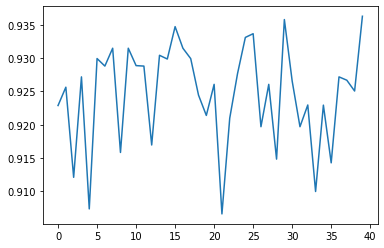

Test 1: Data size 528: :  50%|█████     | 5/10 [06:48<07:45, 93.11s/it, data_size=464, test_acc=0.936, train_acc=0.936]

in al_loop 5
in epoch 0
in epoch 1
in epoch 2
in epoch 3
in epoch 4
in epoch 5
in epoch 6
in epoch 7
in epoch 8
in epoch 9
in epoch 10
in epoch 11
in epoch 12
in epoch 13
in epoch 14
in epoch 15
in epoch 16
in epoch 17
in epoch 18
in epoch 19
in epoch 20
in epoch 21
in epoch 22
in epoch 23
in epoch 24
in epoch 25
in epoch 26
in epoch 27
in epoch 28
in epoch 29
in epoch 30
in epoch 31
in epoch 32
in epoch 33
in epoch 34
in epoch 35
in epoch 36
in epoch 37
in epoch 38
in epoch 39


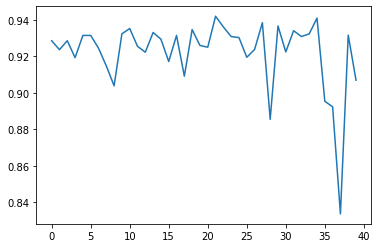

Test 1: Data size 592: :  60%|██████    | 6/10 [09:10<07:18, 109.56s/it, data_size=528, test_acc=0.9, train_acc=0.907] 

in al_loop 6
in epoch 0
in epoch 1
in epoch 2
in epoch 3
in epoch 4
in epoch 5
in epoch 6
in epoch 7
in epoch 8
in epoch 9
in epoch 10
in epoch 11
in epoch 12
in epoch 13
in epoch 14
in epoch 15
in epoch 16
in epoch 17
in epoch 18
in epoch 19
in epoch 20
in epoch 21
in epoch 22
in epoch 23
in epoch 24
in epoch 25
in epoch 26
in epoch 27
in epoch 28
in epoch 29


In [ ]:

tester.test_model(MultiModalLateFusionModelInterface("RANDOM"))

## Get grayscale images to see if that changes things

In [19]:



def load_dataset_as_numpy(max_samples: int = None, grayscale=False):
    def transform_to_multimodal(image):
        main_image_transforms = [
            transforms.CenterCrop(MAIN_IMG_DIMS),
            transforms.ToTensor(),
            #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]
        secondary_image_transforms = [
            transforms.RandomCrop(SECONDARY_IMG_DIMS),
            transforms.ToTensor(),
            #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            transforms.Lambda(lambda img: transforms.functional.adjust_contrast(img, contrast_factor=0.8))
        ]
        
        
        if grayscale:
            main_image_transforms.append(transforms.Grayscale(len(image.getbands())))
            secondary_image_transforms.append(transforms.Grayscale(len(image.getbands())))
            
        main_image = transforms.Compose(main_image_transforms)(image.copy())

        secondary_images = [
            transforms.Compose(secondary_image_transforms)(image.copy()) for i in range(MAX_SECONDARY_IMAGES)
        ]
        secondary_images = torch.stack(secondary_images)
        
        return main_image, secondary_images

    dataset = datasets.ImageFolder(DATA_DIR, transform=transform_to_multimodal)
    output_sample_count = len(dataset) if max_samples is None or max_samples >= len(dataset) else max_samples
    all_data_dataloader = torch.utils.data.DataLoader(dataset, batch_size=output_sample_count, num_workers=0, shuffle=True)
    (main_image_all, secondary_images_all), y_all = next(iter(all_data_dataloader))

    # Convert y to one-hot array
    y_all = torch.eye(NUM_CLASSES)[y_all]

    return main_image_all.numpy(), secondary_images_all.numpy(), y_all.numpy()



def display_samples(x_main, x_secondary):
    print(np.mean(x_main[0]))
    for i in range(4):
        print(f"Label = {y[i]}")
        plt.imshow(x_main[i].transpose(1, 2, 0))
        plt.show()
        fig, axarr = plt.subplots(1, MAX_SECONDARY_IMAGES)
        for j in range(MAX_SECONDARY_IMAGES):
            axarr[j].imshow(x_secondary[i][j].transpose(1, 2, 0))
        plt.show()
    plt.close('all')





In [20]:
# Display some examples
x_main, x_secondary, y = load_dataset_as_numpy(grayscale=False)
x_main_gray, x_secondary_gray, y = load_dataset_as_numpy(grayscale=True)

In [21]:

# Display some examples
#display_samples(x_main,x_secondary)
print(x_main.shape)
print(x_main_gray.shape)
#display_samples(x_main,x_secondary)

(4624, 3, 64, 64)
(4624, 3, 64, 64)


0.5760631
Label = [0. 0. 1. 0.]


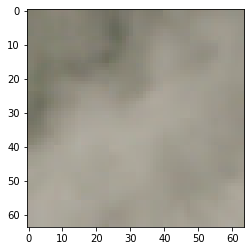

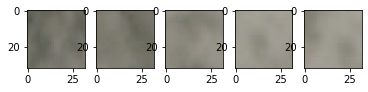

Label = [1. 0. 0. 0.]


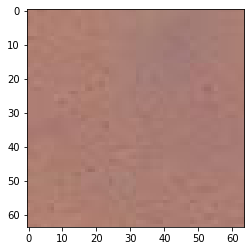

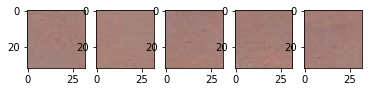

Label = [0. 0. 1. 0.]


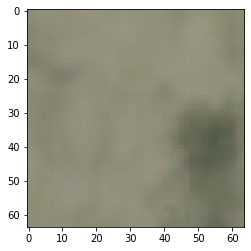

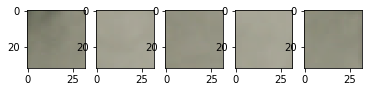

Label = [0. 0. 1. 0.]


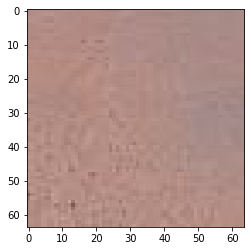

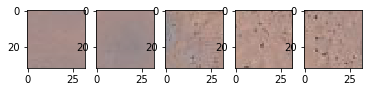

In [22]:
display_samples(x_main,x_secondary)

0.21607876
Label = [0. 0. 1. 0.]


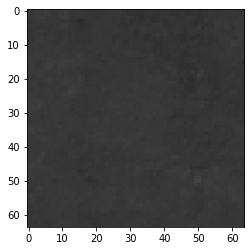

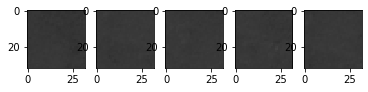

Label = [1. 0. 0. 0.]


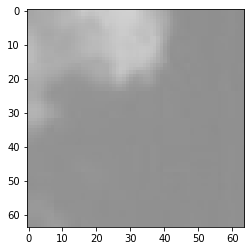

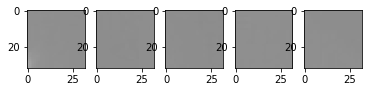

Label = [0. 0. 1. 0.]


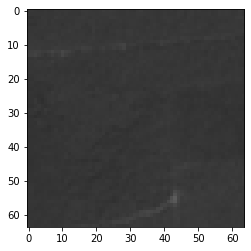

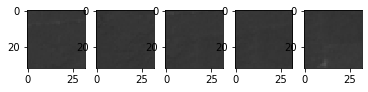

Label = [0. 0. 1. 0.]


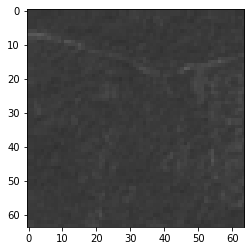

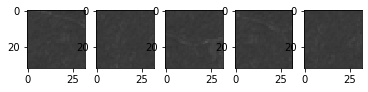

In [23]:
display_samples(x_main_gray,x_secondary_gray)